In [1]:
#Scenario 2: bistable state
#2.1.a: short simulation duration, constant target
#2.1.b: long simulation duration, constant target
#2.2.a: short simulation duration, sin target
#2.2.b: long simulation duration, sin target

In [2]:
# change to the root directory of the project
import os
if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    
path = os.getcwd()
import sys
if path not in sys.path:
    sys.path.append(path)
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

import matplotlib.pyplot as plt
import numpy as np
#import testing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Let's import the aln model
from neurolib.models.aln import ALNModel

# Some useful functions are provided here
import neurolib.utils.functions as func

aln = ALNModel()

In [4]:
def plot_rate(model, control_, target_ = None):
    aln.run( control = control_ )
    time = model['t']

    fig, ax = plt.subplots()

    ax.plot(time, model['rates_exc'].T, lw=2, c='k', label='Exc activity')
    ax.set_xlabel("t [ms]")
    ax.set_ylabel("Rate [Hz]")
    ax.set_xlim([0,model.params['duration']])
    
    if type(target_) != type(None):
        ax.plot(time, target_[0,0,:], lw=2, c='yellow', label='Target')

    #ax2 = ax.twinx()
    #ax2.plot(time, control_[0,0,:]/5., lw=1, c='red', label='Exc control')
    #ax2.plot(time, control_[0,1,:]/5., lw=1, c='blue', label='Inh control')
    #ax2.set_xlabel("t [ms]")
    #ax2.set_ylabel("Control current [nA]")

    plt.legend()
    plt.show()

oscillatory state


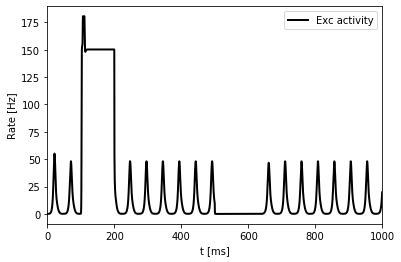

In [5]:
#initialize model

def set_aln_init_zero():
    N = aln.params.N
    aln.params.mufe_init = 0 * np.random.uniform(0, 1, (N,))  # mV/ms
    aln.params.mufi_init = 0 * np.random.uniform(0, 1, (N,))  # mV/ms
    aln.params.seem_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.seim_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.seev_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.seiv_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.siim_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.siem_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.siiv_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.siev_init = 0. * np.random.uniform(0, 1, (N,))
    aln.params.rates_exc_init = 0. * np.random.uniform(0, 1, (N, 1))
    aln.params.rates_inh_init = 0. * np.random.uniform(0, 1, (N, 1))
    aln.params.IA_init = 0.0 * np.zeros((N, 1))  # pA
    aln.params.mue_ou = 0. * np.random.uniform(0, 1, (N,))
    aln.params.mui_ou = 0. * np.random.uniform(0, 1, (N,))

# reads final state of model dynamics
# set before simulation such that system begins in stable state
def read_state():
    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]
    return init_state_vars
    
aln = ALNModel()
set_aln_init_zero()
aln.params.a = 0. # no adaptation
aln.params.b = 0. # no adaptation
aln.params.ext_exc_current = 0.
aln.params.ext_inh_current = 0.
aln.params['duration'] = 1000. 

control0 = aln.getZeroControl()
control0[0,0,1000:2000] = 5.
control0[0,0,5000:6000] = -5.

state_vars = aln.state_vars

# oscillatory state
print("oscillatory state")
aln.params.mue_ext_mean = 0.2 * 5.
aln.params.mui_ext_mean = 0.1 * 5.
    
plot_rate(aln, control0)
init_osc = read_state()

In [6]:
 # to set initial parameters
def setinit(init_vars_, model):
    
    for iv in range(len(model.init_vars)):
        for sv in range(len(model.state_vars)):
            if model.state_vars[sv] in model.init_vars[iv]:
                if model.params[model.init_vars[iv]].ndim == 2:
                    model.params[model.init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[model.init_vars[iv]][0] = init_vars_[sv]

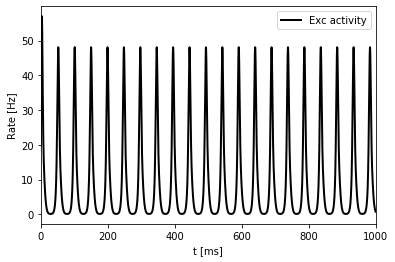

In [7]:
# fixed initialization should imply reproducibility, try also for other cases

aln = ALNModel()
set_aln_init_zero()
aln.params.a = 0. # no adaptation
aln.params.b = 0. # no adaptation
aln.params.ext_exc_current = 0.
aln.params.ext_inh_current = 0.
aln.params['duration'] = 1000. 
aln.params.mue_ext_mean = 0.2 * 5.  # try also other cases parameters
aln.params.mui_ext_mean = 0.1 * 5.
setinit(init_osc, aln)

control0 = aln.getZeroControl()
plot_rate(aln, control0)

In [23]:
# set parameters
tol = 1e-12 # algorithm tolerance for convergence

start_step = 10. # start step of gradient descent

c_scheme = np.zeros(( 1,1 )) # coupling scheme, only relevant for networks
c_scheme[0,0] = 1. # coupling scheme, only relevant for networks
u_mat = np.identity(1) # control matrix
u_scheme = np.array([[1.]]) # control scheme

max_it = 1000 # maximum number of iterations

max_cntrl = [5., 5., 0., 0., 0., 0.] # maximum value of control current in input nodes (exc current, inh current, rates)
min_cntrl = [-5., -5., 0., 0., 0., 0.]

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ"] # different gradient descent methods
cgv = cgv_list[0]

In [24]:
# scenario 2.1.a
# const target, short sim time
dur = 20. # simulation duration
aln.params.duration = dur
setinit(init_osc, aln)

control0 = aln.getZeroControl()
control0[0,0,-100:] = 1.

target_const = aln.getZeroTarget()
target_const[0,0,:] = 50

# oscillation should be somewhat realistic, so roughly like what we find in stable oscillatory states.
# One period is roughly 40ms
target_osc = aln.getZeroTarget()
x_osc = np.arange(0.,dur+aln.params.dt,aln.params.dt)
target_osc[0,0,:] = 25. + 25. * np.sin(0.2 * x_osc)

In [26]:
#scenario 2.1.a

max_it_ = 400
cost_list_21a = []
runtime_list_21a = []
termination_it_21a = []
best_control_list_21a = []

for cgv_tmp in cgv_list:
    setinit(init_osc, aln)
    bestControl, bestState, cost, runtime, gradient, adjoint, costnode = aln.A1(
        control0, target_const, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = 0., t_sim_post_ = 0., CGVar = cgv_tmp, control_variables_ = [0],
        prec_variables_ = [0], transition_time_ = 0.25)
    
    best_control_list_21a.append(bestControl)
    cost_list_21a.append(cost)
    runtime_list_21a.append(runtime)
    
    for cost_ind in range(len(cost)):
        if cost[cost_ind] == 0.:
            termination_it_21a.append(cost_ind-1)
            break

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5276.780396598823
Gradient descend method:  None
RUN  1 , total integrated cost =  426.06079046349225
RUN  2 , total integrated cost =  104.64382773473794
RUN  3 , total integrated cost =  42.38577785639163
RUN  4 , total integrated cost =  27.942272421273245
RUN  5 , total integrated cost =  23.293660661685845
RUN  6 , total integrated cost =  21.43571750347288
RUN  7 , total integrated cost =  20.24442218335699
RUN  8 , total integrated cost =  19.548910693988752
RUN  9 , total integrated cost =  18.96376441644412
RUN  10 , total integrated cost =  18.589105327761445
RUN  11 , total integrated cost =  18.20877215670465
RUN  12 , total integrated cost =  17.97913086681004
RUN  13 , total integrated cost =  17.585340845002943
RUN  14 , total integrated cost =  17.423503282170575
RUN  15 , total integrated cost =  17.090362066243692
RUN  16 , total integrated cost =  17.073720586046573
RUN  17 , total integrated cos

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  40 , total integrated cost =  16.92944236572297
Control only changes marginally.
RUN  48 , total integrated cost =  16.929442285897043
Improved over  48  iterations in  0.4821190000000115  seconds by  99.67917099038631  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5276.780396598823
Gradient descend method:  HS
RUN  1 , total integrated cost =  426.06079046349225
RUN  2 , total integrated cost =  59.30438086621481
RUN  3 , total integrated cost =  30.654220177267874
RUN  4 , total integrated cost =  22.565490778058837
RUN  5 , total integrated cost =  20.03597198918276
RUN  6 , total integrated cost =  18.594616384785198
RUN  7 , total integrated cost =  17.74395122774437
RUN  8 , total integrated cost =  17.502296693222803
RUN  9 , total integrated cost =  17.360421695658296


ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  10 , total integrated cost =  17.23315057221089
RUN  11 , total integrated cost =  17.15156285624972
RUN  12 , total integrated cost =  17.092684074647405
RUN  13 , total integrated cost =  17.064960203013197
RUN  14 , total integrated cost =  17.04979783808103
RUN  15 , total integrated cost =  17.02734316358589
RUN  16 , total integrated cost =  17.004830111289984
RUN  17 , total integrated cost =  16.99203019752884
RUN  18 , total integrated cost =  16.96650361527412
RUN  19 , total integrated cost =  16.953143034093884
RUN  20 , total integrated cost =  16.948367429194025
Control only changes marginally.
RUN  23 , total integrated cost =  16.934519262738018
Improved over  23  iterations in  0.24657460000003084  seconds by  99.67907477685345  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5276.780396598823
Gradient descend method:  FR
RUN  1 , total integrated cost =  426.06079046349225
RUN  2 , total integrated cost =  72.66347093411773
RUN  3

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  1000 , total integrated cost =  16.866698028688518
RUN  1000 , total integrated cost =  16.866698028688518
Improved over  1000  iterations in  9.511992400000054  seconds by  99.68036005365013  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5276.780396598823
Gradient descend method:  PR
RUN  1 , total integrated cost =  426.06079046349225
RUN  2 , total integrated cost =  59.27164156222836
RUN  3 , total integrated cost =  30.611585899405526
RUN  4 , total integrated cost =  22.21235805026875
RUN  5 , total integrated cost =  19.834691713459595
RUN  6 , total integrated cost =  18.67837186089104
RUN  7 , total integrated cost =  17.75697222861099
RUN  8 , total integrated cost =  17.511293172900093
RUN  9 , total integrated cost =  17.376294898294212
RUN  10 , total integrated cost =  17.264437846769972
RUN  11 , total integrated cost =  17.123338585177024
RUN  12 , total integrated cost =  17.0881676360762
RUN  13 , total integrated cost =  17.067

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  32 , total integrated cost =  16.90239881761825
Improved over  32  iterations in  0.3689360999999849  seconds by  99.67968348979403  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5276.780396598823
Gradient descend method:  CD
RUN  1 , total integrated cost =  426.06079046349225
RUN  2 , total integrated cost =  72.66347093411773
RUN  3 , total integrated cost =  29.707863618873976
RUN  4 , total integrated cost =  22.49362886824305
RUN  5 , total integrated cost =  20.457017561745154
RUN  6 , total integrated cost =  18.65277906494893
RUN  7 , total integrated cost =  18.021427984584513
RUN  8 , total integrated cost =  17.67560133100524
RUN  9 , total integrated cost =  17.59292633588671
RUN  10 , total integrated cost =  17.483289122405992
RUN  11 , total integrated cost =  17.394228340354015
RUN  12 , total integrated cost =  17.348293101943987
RUN  13 , total integrated cost =  17.313903503592346
RUN  14 , total integrated cost =  17.29319330

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  110 , total integrated cost =  16.90024766682854
Control only changes marginally.
RUN  116 , total integrated cost =  16.900247666828143
Improved over  116  iterations in  1.0257641000000035  seconds by  99.6797242561445  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5276.780396598823
Gradient descend method:  LS
RUN  1 , total integrated cost =  426.06079046349225
RUN  2 , total integrated cost =  59.27164156222836
RUN  3 , total integrated cost =  31.059503906965034
RUN  4 , total integrated cost =  22.691579896160718
RUN  5 , total integrated cost =  20.372189256536323
RUN  6 , total integrated cost =  18.79343569242441
RUN  7 , total integrated cost =  17.951620846353933
RUN  8 , total integrated cost =  17.722846360345624
RUN  9 , total integrated cost =  17.578351233608572
RUN  10 , total integrated cost =  17.42100654083627
RUN  11 , total integrated cost =  17.316986884592694
RUN  12 , total integrated cost =  17.19372791667977
RUN  13 , 

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  40 , total integrated cost =  16.946002170096143
Control only changes marginally.
RUN  41 , total integrated cost =  16.94600217009614
Improved over  41  iterations in  0.4472154000000046  seconds by  99.67885716485343  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5276.780396598823
Gradient descend method:  DY
RUN  1 , total integrated cost =  426.06079046349225
RUN  2 , total integrated cost =  73.19238884321096
RUN  3 , total integrated cost =  29.26298825520542
RUN  4 , total integrated cost =  22.185078572140842
RUN  5 , total integrated cost =  19.065020955219964
RUN  6 , total integrated cost =  18.353474946992662
RUN  7 , total integrated cost =  17.741577731340605
RUN  8 , total integrated cost =  17.453671162141056
RUN  9 , total integrated cost =  17.313602979512062
RUN  10 , total integrated cost =  17.198019769915884
RUN  11 , total integrated cost =  17.112870260573835
RUN  12 , total integrated cost =  17.066109025534832
RUN  13 , 

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


 60 , total integrated cost =  16.883561438599706
RUN  70 , total integrated cost =  16.88257484861336
Control only changes marginally.
RUN  70 , total integrated cost =  16.88257484861336
Improved over  70  iterations in  0.6853290000000243  seconds by  99.68005917283396  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5276.780396598823
Gradient descend method:  WYL
RUN  1 , total integrated cost =  426.06079046349225
RUN  2 , total integrated cost =  69.15758124443646
RUN  3 , total integrated cost =  31.553897002032578
RUN  4 , total integrated cost =  23.330445075269942
RUN  5 , total integrated cost =  21.004341106912904
RUN  6 , total integrated cost =  18.758670303327165
RUN  7 , total integrated cost =  18.16066710310301
RUN  8 , total integrated cost =  17.686094309165163
RUN  9 , total integrated cost =  17.523463242436538
RUN  10 , total integrated cost =  17.36652481881705
RUN  11 , total integrated cost =  17.253048219874337
RUN  12 , total

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  30 , total integrated cost =  16.925587564210556
RUN  40 , total integrated cost =  16.906797667306755
Control only changes marginally.
RUN  45 , total integrated cost =  16.906797626391587
Improved over  45  iterations in  0.4677513999999974  seconds by  99.67960012819012  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5276.780396598823
Gradient descend method:  HZ
RUN  1 , total integrated cost =  426.06079046349225
RUN  2 , total integrated cost =  104.64583613571261
RUN  3 , total integrated cost =  34.8049887716681
RUN  4 , total integrated cost =  24.935468537575282
RUN  5 , total integrated cost =  21.253628527055046
RUN  6 , total integrated cost =  19.5636368659634
RUN  7 , total integrated cost =  18.38289036695261
RUN  8 , total integrated cost =  18.048953752598685
RUN  9 , total integrated cost =  17.568494770639337
RUN  10 , total integrated cost =  17.39441504211222
RUN  11 , total integrated cost =  17.254840662464765
RUN  12 , tot

In [ ]:
for cgv_ind in range(len(cgv_list)):
    plot_rate(aln, best_control_list_21a[cgv_ind], target_const)

In [ ]:
marker_ = '.'
markersize_ = 3
linestyle_ = ''

fig, ax = plt.subplots(2, figsize=(8,8))

for i in range(len(termination_it_21a)):
    ax[0].plot(runtime_list_21a[i][:termination_it_21a[i]], cost_list_21a[i][:termination_it_21a[i]], marker=marker_,
             markersize = markersize_, linestyle=linestyle_, label = str(cgv_list[i]))
    performance = []
    for j in range(termination_it_21a[i]):
        performance.append( 100. * ( cost_list_21a[i][0] - cost_list_21a[i][j]) / cost_list_21a[i][0] ) 
    ax[1].plot(runtime_list_21a[i][:termination_it_21a[i]], performance, marker=marker_,
            markersize = markersize_, linestyle=linestyle_,
            label = str(cgv_list[i]) + ', termination at {:.2f}'.format(performance[-1]) + '% after ' + str(termination_it_21a[i]) + ' iterations' )
ax[0].legend()
ax[0].set_xlabel('Runtime [s]')
ax[0].set_ylabel('Cost')
#ax[0].title.set_text('Cost per runtime')
ax[1].legend()
ax[1].set_xlabel('Runtime [s]')
ax[1].set_ylabel('Improvement [%]')
#ax[0].title.set_text('Cost per runtime')


plt.show()

In [27]:
#scenario 2.2.a

max_it_ = 400
cost_list_22a = []
runtime_list_22a = []
termination_it_22a = []
best_control_list_22a = []

for cgv_tmp in cgv_list:
    setinit(init_osc, aln)
    bestControl, bestState, cost, runtime, gradient, adjoint, costnode = aln.A1(
        control0, target_osc, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = 0., t_sim_post_ = 0., CGVar = cgv_tmp, control_variables_ = [0],
        prec_variables_ = [0], transition_time_ = 0.25)
    
    best_control_list_22a.append(bestControl)
    cost_list_22a.append(cost)
    runtime_list_22a.append(runtime)
    
    for cost_ind in range(len(cost)):
        if cost[cost_ind] == 0.:
            termination_it_22a.append(cost_ind-1)
            break

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3890.47150224489
Gradient descend method:  None
RUN  1 , total integrated cost =  548.8034068751293
RUN  2 , total integrated cost =  106.38251202740504
RUN  3 , total integrated cost =  31.79732146318503
RUN  4 , total integrated cost =  22.165945078125016
RUN  5 , total integrated cost =  17.80346659582818
RUN  6 , total integrated cost =  15.10327106725526
RUN  7 , total integrated cost =  13.585089947424478
RUN  8 , total integrated cost =  12.437904138980588
RUN  9 , total integrated cost =  11.782684379649613
RUN  10 , total integrated cost =  11.062031318059761
RUN  11 , total integrated cost =  10.70641590588677
RUN  12 , total integrated cost =  9.972553538498712
RUN  13 , total integrated cost =  9.749676877817455
RUN  14 , total integrated cost =  9.595132413748503
RUN  15 , total integrated cost =  9.441597731909232
RUN  16 , total integrated cost =  9.423561825580133
RUN  17 , total integrated cost =  

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  50 , total integrated cost =  8.769015085024147
Control only changes marginally.
RUN  57 , total integrated cost =  8.769015084936605
Improved over  57  iterations in  0.5377788000000123  seconds by  99.77460276781679  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3890.47150224489
Gradient descend method:  HS
RUN  1 , total integrated cost =  548.8034068751293
RUN  2 , total integrated cost =  173.13937955608796
RUN  3 , total integrated cost =  51.918284603816375
RUN  4 , total integrated cost =  25.523256351514867
RUN  5 , total integrated cost =  14.270618347942829
RUN  6 , total integrated cost =  12.279762800549038
RUN  7 , total integrated cost =  11.007912296613117
RUN  8 , total integrated cost =  10.176563487230382
RUN  9 , total integrated cost =  9.751824739628832
RUN  10 , total integrated cost =  9.490374734049984
RUN  11 , total integrated cost =  9.367050089645549
RUN  12 , total integrated cost =  9.296732366465744
RUN  13 , total

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


Control only changes marginally.
RUN  41 , total integrated cost =  8.619253728958697
Improved over  41  iterations in  0.46301610000000437  seconds by  99.77845220755414  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3890.47150224489
Gradient descend method:  FR
RUN  1 , total integrated cost =  548.8034068751293
RUN  2 , total integrated cost =  169.46953450994633
RUN  3 , total integrated cost =  84.85875147968659
RUN  4 , total integrated cost =  44.31542493458001
RUN  5 , total integrated cost =  34.89295634357534
RUN  6 , total integrated cost =  24.069524432604783
RUN  7 , total integrated cost =  16.153199945481404
RUN  8 , total integrated cost =  14.113519360045698
RUN  9 , total integrated cost =  12.814494277230343
RUN  10 , total integrated cost =  11.789722084968671
RUN  11 , total integrated cost =  11.217264629438237
RUN  12 , total integrated cost =  10.687926771697434
RUN  13 , total integrated cost =  10.162218959751897
RUN  14 , to

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  1000 , total integrated cost =  8.63392465428791
RUN  1000 , total integrated cost =  8.63392465428791
Improved over  1000  iterations in  8.90496539999998  seconds by  99.77807510865185  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3890.47150224489
Gradient descend method:  PR
RUN  1 , total integrated cost =  548.8034068751293
RUN  2 , total integrated cost =  174.0086217360995
RUN  3 , total integrated cost =  51.90240649644047
RUN  4 , total integrated cost =  26.752316808470866
RUN  5 , total integrated cost =  15.882786374686983
RUN  6 , total integrated cost =  12.857897627064055
RUN  7 , total integrated cost =  11.26631528990559
RUN  8 , total integrated cost =  10.41256760448092
RUN  9 , total integrated cost =  10.040038597987266
RUN  10 , total integrated cost =  9.760700917586178
RUN  11 , total integrated cost =  9.598433796026752
RUN  12 , total integrated cost =  9.392688005101256
RUN  13 , total integrated cost =  9.190127870580

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


Control only changes marginally.
RUN  38 , total integrated cost =  8.663886135517263
Improved over  38  iterations in  0.41673679999996693  seconds by  99.77730498397128  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3890.47150224489
Gradient descend method:  CD
RUN  1 , total integrated cost =  548.8034068751293
RUN  2 , total integrated cost =  169.46953450994633
RUN  3 , total integrated cost =  85.31605721589436
RUN  4 , total integrated cost =  42.856782269808846
RUN  5 , total integrated cost =  34.181582538612986
RUN  6 , total integrated cost =  22.781053166373713
RUN  7 , total integrated cost =  14.520990951712056
RUN  8 , total integrated cost =  13.035457255731076
RUN  9 , total integrated cost =  11.616453805927874
RUN  10 , total integrated cost =  11.045936921589531
RUN  11 , total integrated cost =  10.371509651700654
RUN  12 , total integrated cost =  9.98481649872948
RUN  13 , total integrated cost =  9.784727774919808
RUN  14 , tot

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  160 , total integrated cost =  8.654088723806787
RUN  170 , total integrated cost =  8.654088723805001
Control only changes marginally.
RUN  173 , total integrated cost =  8.654088723804987
Improved over  173  iterations in  1.8899019000000408  seconds by  99.77755681493075  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3890.47150224489
Gradient descend method:  LS
RUN  1 , total integrated cost =  548.8034068751293
RUN  2 , total integrated cost =  174.0086217360995
RUN  3 , total integrated cost =  51.9442187217055
RUN  4 , total integrated cost =  26.880334664005574
RUN  5 , total integrated cost =  15.759908224075977
RUN  6 , total integrated cost =  12.840490189940962
RUN  7 , total integrated cost =  11.267721492638753
RUN  8 , total integrated cost =  10.386805130658756
RUN  9 , total integrated cost =  10.088342242524668
RUN  10 , total integrated cost =  9.793902173991418
RUN  11 , total integrated cost =  9.621676253829825
RUN  12 , tot

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  40 , total integrated cost =  8.693483874298607
Control only changes marginally.
RUN  44 , total integrated cost =  8.681849171257054
Improved over  44  iterations in  0.5675838999999883  seconds by  99.77684326523797  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3890.47150224489
Gradient descend method:  DY
RUN  1 , total integrated cost =  548.8034068751293
RUN  2 , total integrated cost =  168.67858968617247
RUN  3 , total integrated cost =  87.16665611234045
RUN  4 , total integrated cost =  40.47431382630858
RUN  5 , total integrated cost =  32.6623488572925
RUN  6 , total integrated cost =  23.47430023334986
RUN  7 , total integrated cost =  14.886792129961794
RUN  8 , total integrated cost =  13.352547224330982
RUN  9 , total integrated cost =  11.918226342312538
RUN  10 , total integrated cost =  11.177161650304793
RUN  11 , total integrated cost =  10.75050738216164
RUN  12 , total integrated cost =  10.122334557127914
RUN  13 , total i

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  70 , total integrated cost =  8.737295287912303
Control only changes marginally.
RUN  76 , total integrated cost =  8.737295287912147
Improved over  76  iterations in  1.066591599999981  seconds by  99.77541808793946  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3890.47150224489
Gradient descend method:  WYL
RUN  1 , total integrated cost =  548.8034068751293
RUN  2 , total integrated cost =  171.37381044111615
RUN  3 , total integrated cost =  68.31687896236654
RUN  4 , total integrated cost =  36.63227085059206
RUN  5 , total integrated cost =  24.18466004814298
RUN  6 , total integrated cost =  14.837194612579076
RUN  7 , total integrated cost =  12.300237509737519
RUN  8 , total integrated cost =  11.34927141944144
RUN  9 , total integrated cost =  10.210110377905675
RUN  10 , total integrated cost =  9.747138328559073
RUN  11 , total integrated cost =  9.518955240939716
RUN  12 , total integrated cost =  9.360276624580944
RUN  13 , total in

ERROR:root:Not possible to set up initial conditions without sufficient simulation time before control


RUN  30 , total integrated cost =  8.721309031848245
Control only changes marginally.
RUN  38 , total integrated cost =  8.655601791173567
Improved over  38  iterations in  0.5578327000000058  seconds by  99.77751792331138  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3890.47150224489
Gradient descend method:  HZ
RUN  1 , total integrated cost =  548.8034068751293
RUN  2 , total integrated cost =  162.71709523596402
RUN  3 , total integrated cost =  45.953192170209135
RUN  4 , total integrated cost =  26.604024749257718
RUN  5 , total integrated cost =  17.710816307625056
RUN  6 , total integrated cost =  12.435254300391486
RUN  7 , total integrated cost =  11.550109095854065
RUN  8 , total integrated cost =  10.610754475866015
RUN  9 , total integrated cost =  10.115168229598044
RUN  10 , total integrated cost =  9.848652535726542
RUN  11 , total integrated cost =  9.648688057370455
RUN  12 , total integrated cost =  9.403182905124087
RUN  13 , tota

In [ ]:
for cgv_ind in range(len(cgv_list)):
    plot_rate(aln, best_control_list_22a[cgv_ind], target_osc)

In [ ]:
marker_ = '.'
markersize_ = 3
linestyle_ = ''

fig, ax = plt.subplots(2, figsize=(8,8))

for i in range(len(termination_it_22a)):
    ax[0].plot(runtime_list_22a[i][:termination_it_22a[i]], cost_list_22a[i][:termination_it_22a[i]], marker=marker_,
             markersize = markersize_, linestyle=linestyle_, label = str(cgv_list[i]))
    performance = []
    for j in range(termination_it_22a[i]):
        performance.append( 100. * ( cost_list_22a[i][0] - cost_list_22a[i][j]) / cost_list_22a[i][0] ) 
    ax[1].plot(runtime_list_22a[i][:termination_it_22a[i]], performance, marker=marker_,
            markersize = markersize_, linestyle=linestyle_,
            label = str(cgv_list[i]) + ', termination at {:.2f}'.format(performance[-1]) + '% after ' + str(termination_it_22a[i]) + ' iterations' )
ax[0].legend()
ax[0].set_xlabel('Runtime [s]')
ax[0].set_ylabel('Cost')
#ax[0].title.set_text('Cost per runtime')
ax[1].legend()
ax[1].set_xlabel('Runtime [s]')
ax[1].set_ylabel('Improvement [%]')
#ax[0].title.set_text('Cost per runtime')


plt.show()